<a href="https://colab.research.google.com/github/Kazi-Rakib-Hasan-Jawwad/MedMNIST_DL_Benchmark/blob/path_mnist/PathMnist_RN18_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps for connecting to a local runtime:
1. Create a virtual environment (VE) on windows or linux terminal
2. Install dependencies in your VE: jupyter-notebook, medmnist, pytorch-lightning, matplotlib, numpy, pandas, scikit-learn.
3. Put this command in virtual environment terminal:
    
    jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
4. Copy and paste the url in colab.

In [ ]:
!pip install medmnist pytorch-lightning

In [9]:
import medmnist
print(medmnist.__version__)

from medmnist import INFO
!python -m medmnist available

3.0.1
MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist       | PathMNIST       | Size: 28 (default), 64, 128, 224.
	chestmnist      | ChestMNIST      | Size: 28 (default), 64, 128, 224.
	dermamnist      | DermaMNIST      | Size: 28 (default), 64, 128, 224.
	octmnist        | OCTMNIST        | Size: 28 (default), 64, 128, 224.
	pneumoniamnist  | PneumoniaMNIST  | Size: 28 (default), 64, 128, 224.
	retinamnist     | RetinaMNIST     | Size: 28 (default), 64, 128, 224.
	breastmnist     | BreastMNIST     | Size: 28 (default), 64, 128, 224.
	bloodmnist      | BloodMNIST      | Size: 28 (default), 64, 128, 224.
	tissuemnist     | TissueMNIST     | Size: 28 (default), 64, 128, 224.
	organamnist     | OrganAMNIST     | Size: 28 (default), 64, 128, 224.
	organcmnist     | OrganCMNIST     | Size: 28 (default), 64, 128, 224.
	organsmnist     | OrganSMNIST     | Size: 28 (default), 64, 128, 224.
	organmnist3d    | OrganMNIST3D    | Size: 28 (default), 64.
	

Calculated mean and std values for PathMnist_64 is

{tensor([0.7405, 0.5330, 0.7058]) tensor([0.1403, 0.1951, 0.1387])}

tensor([0.7405, 0.5330, 0.7058]) tensor([0.0961, 0.1308, 0.0941])



Dataset PathMNIST of size 28 (pathmnist)

1.   Number of datapoints: 89996
2.   Root location: /root/.medmnist
3.   Split: train, Task: multi-class, Number of channels: 3 (RGB)
4.   Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
5.   Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
6.   Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
7.   License: CC BY 4.0


In [10]:
from torch.utils import data
import torchvision.transforms as transforms

transform1 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # transforms.Normalize([0.7405, 0.5330, 0.7058], [0.1403, 0.1951, 0.1387])
])

In [11]:
num_workers = 6
batch_size = 2048
download = True

info = INFO['pathmnist']
root = "/home/rakib/medical_data/"
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=transform1, download=download, size=64, root=root)
val_dataset = DataClass(split='val', transform=transform1, download=download, size=64, root=root)
test_dataset = DataClass(split='test', transform=transform1, download=download, size=64, root=root)

pil_dataset = DataClass(split='train', download=download, size=64, root=root)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Using downloaded and verified file: /home/rakib/medical_data/pathmnist_64.npz
Using downloaded and verified file: /home/rakib/medical_data/pathmnist_64.npz
Using downloaded and verified file: /home/rakib/medical_data/pathmnist_64.npz
Using downloaded and verified file: /home/rakib/medical_data/pathmnist_64.npz


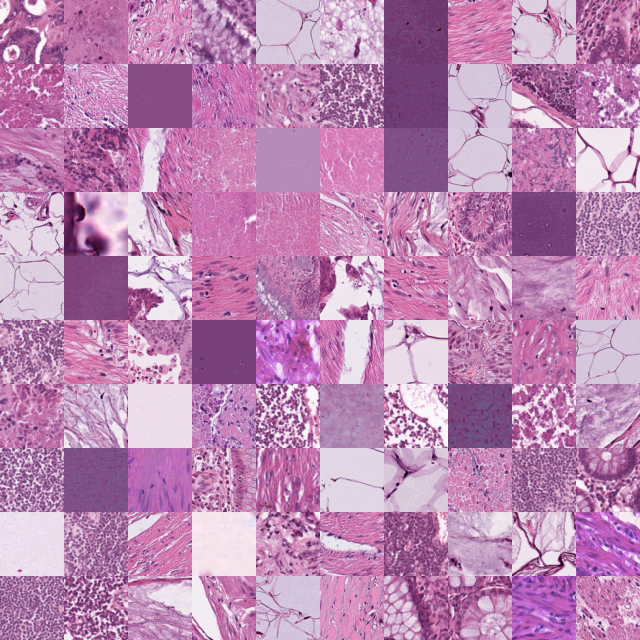

In [ ]:
train_dataset.montage(length=10)

In [12]:
# necessary imports for training
import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy
from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

In [21]:
# ResNet18 classifier

class pl_rn18_Classifier(pl.LightningModule):
    def __init__(self):
        super(pl_rn18_Classifier, self).__init__()
        # Load the pre-trained ResNet18 model
        self.resnet18 = resnet18(pretrained=False, num_classes=9) # Output of last linear layer (512 -> 9)
        #self.resnet18.fc = nn.Linear(512, 9) # Output of last linear layer (512 -> 9)
        self.accuracy = Accuracy(task="multiclass", num_classes=9)

    def forward(self, x):
        return self.resnet18(x)

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(F.log_softmax(logits, dim=1), labels)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()  # Adjust labels to be 1D if necessary
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True, logger=True)
        self.log('learning_rate', self.optimizers().param_groups[0]['lr'], prog_bar=True, logger=True)  # Log learning rate
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()  # Adjust labels to be 1D if necessary
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_acc', self.accuracy(logits, y), prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.squeeze()  # Adjust labels to be 1D if necessary
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy(logits, y), prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
        scheduler = {
            'scheduler': lr_scheduler,
            'interval': 'epoch',  # Step the scheduler every epoch
            'frequency': 1,  # Every epoch
        }
        return [optimizer], [scheduler]


In [22]:
# Initialize the TensorBoard logger
tensorboard_logger = TensorBoardLogger("/home/rakib/checkpoints/v18", name="")

model = pl_rn18_Classifier()

# Initialize the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',      # Metric to monitor
    dirpath='checkpoints/v18/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Filename format
    save_top_k=3,            # Save only the best 2 models
    mode='min'               # Mode to compare metric ('min' for val_loss, 'max' for accuracy)
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=25,
    verbose=True,
    mode='min'
)
# Add TQDMProgressBar callback
# progress_bar_callback = TQDMProgressBar(refresh_rate=1)
# Initialize the Trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    callbacks=[checkpoint_callback], #, early_stopping_callback
    logger=tensorboard_logger,  # Pass the TensorBoard logger here
    log_every_n_steps=1
)

/home/rakib/project-6/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rakib/project-6/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
# Train the model
trainer.fit(model, train_loader, val_loader)

/home/rakib/project-6/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/rakib/checkpoints/v18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | resnet18 | ResNet             | 11.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


 Results without early stopping

 test accuracy: .868802, loss: .830850

# Results with early stopping. stoped at step 1606 (after 72 epoch) [22 step = 1 epoch, for batch size 4096]

 test accuracy: .870473, loss: .900101

In [24]:
# Test the best model
trainer.test(model, test_loader)# v8 results without early stopping
test_dataset2 = DataClass(split='test', transform=transforms.ToTensor(), download=download, size=28, root=root) #root=root # only in local setup
test_loader2 = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# Test the best model
trainer.test(model, test_loader2)
test_dataset3 = DataClass(split='test', transform=transforms.ToTensor(), download=download, size=128, root=root) #root=root # only in local setup
test_loader3 = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# Test the best model
trainer.test(model, test_loader3)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8818941712379456
        test_loss           0.9130657911300659
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using downloaded and verified file: /home/rakib/medical_data/pathmnist.npz


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8818941712379456
        test_loss           0.9130658507347107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Using downloaded and verified file: /home/rakib/medical_data/pathmnist_128.npz


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8818941712379456
        test_loss           0.9130658507347107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9130658507347107, 'test_acc': 0.8818941712379456}]

In [37]:
classes = test_dataset.info["label"]
print(classes)
class_names = [classes[str(i)] for i in range(len(classes))]
print(class_names)

{'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']


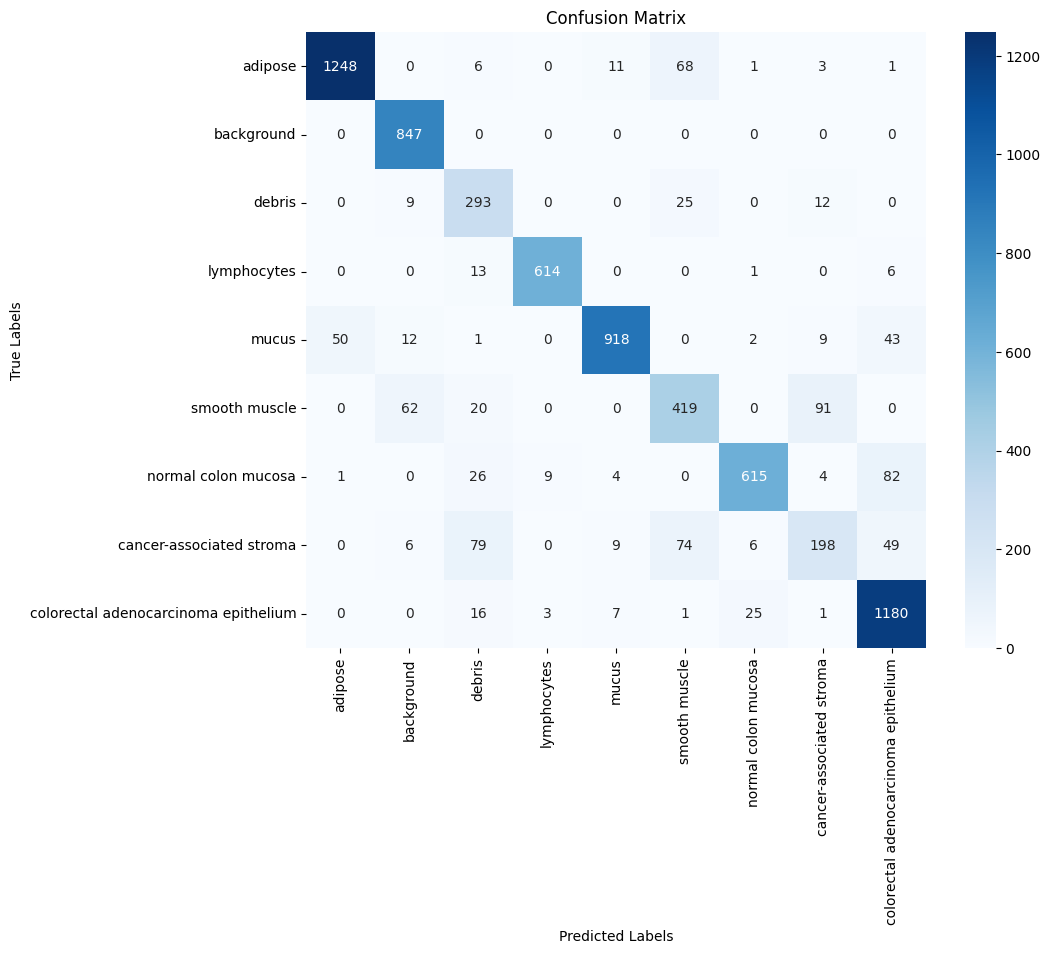

In [39]:
# Assuming 'model' is your trained model, and 'dataloader' is your DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda")
model.to(device)
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for x, y in iter(test_loader):
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        y_pred_class = torch.argmax(y_pred, dim=1)  # Get the predicted class

        true_labels.append(y.cpu().numpy())
        pred_labels.append(y_pred_class.cpu().numpy())

# Concatenate the lists to create complete arrays
true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/home/rakib/checkpoints/v18/rn18_default_noaugment_cm", dpi=600)
plt.show()


# Augmented Data Train

In [25]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=64),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [26]:
# main change: transform function
num_workers = 6
batch_size = 2048
download = True

info = INFO['pathmnist']
root = "/home/rakib/medical_data/"
DataClass = getattr(medmnist, info['python_class'])
# load the data
augmented_train_dataset = DataClass(split='train', transform=contrast_transforms, download=download, size=64, root=root) #, root=root) # only in local setup
augmented_val_dataset = DataClass(split='val', transform=contrast_transforms, download=download, size=64, root=root) #root=root # only in local setup

# encapsulate data into dataloader form
augmented_train_loader = data.DataLoader(dataset=augmented_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
augmented_val_loader = data.DataLoader(dataset=augmented_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Using downloaded and verified file: /home/rakib/medical_data/pathmnist_64.npz
Using downloaded and verified file: /home/rakib/medical_data/pathmnist_64.npz


In [27]:
# 2nd Trainer

# Initialize the TensorBoard logger
tensorboard_logger = TensorBoardLogger("/home/rakib/checkpoints/v19", name="")


# Initialize the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',      # Metric to monitor
    dirpath='checkpoints/v19/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Filename format
    save_top_k=3,            # Save only the best 2 models
    mode='max'               # Mode to compare metric ('min' for val_loss, 'max' for accuracy)
)
early_stopping_callback = EarlyStopping(
    monitor='val_acc',
    patience=25,
    verbose=True,
    mode='max'
)

# Initialize the Trainer
trainer3 = pl.Trainer(
    max_epochs=100,
    accelerator="auto",
    callbacks=[checkpoint_callback], #, early_stopping_callback
    logger=tensorboard_logger,  # Pass the TensorBoard logger here
    log_every_n_steps=2
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
model2 = pl_rn18_Classifier()

# Train the model
trainer3.fit(model2, augmented_train_loader, augmented_val_loader)

Missing logger folder: /home/rakib/checkpoints/v19/
/home/rakib/project-6/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/rakib/checkpoints/v19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | resnet18 | ResNet             | 11.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [29]:
# Test the best model
trainer3.test(model2, test_loader)# v8 results with early stopping. stoped at step 1606 (after 72 epoch)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8380222916603088
        test_loss           0.5100907683372498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5100907683372498, 'test_acc': 0.8380222916603088}]

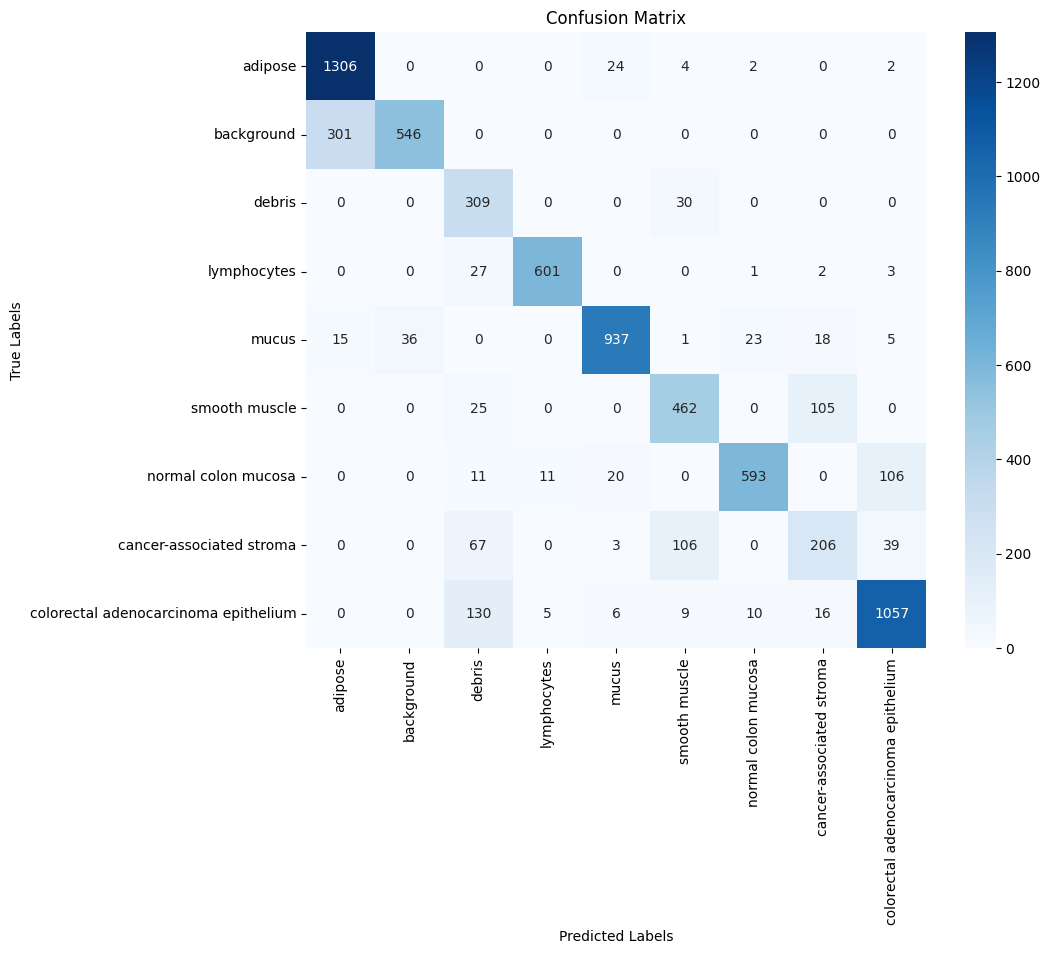

In [40]:
model2.to(device)
model2.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for x, y in iter(test_loader):
        x = x.to(device)
        y = y.to(device)

        y_pred = model2(x)
        y_pred_class = torch.argmax(y_pred, dim=1)  # Get the predicted class

        true_labels.append(y.cpu().numpy())
        pred_labels.append(y_pred_class.cpu().numpy())

# Concatenate the lists to create complete arrays
true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/home/rakib/checkpoints/v19/rn18_default_augment_cm", dpi=600)
plt.show()